# Skin Disease Classification with Deep Learning 
  
Bu projede, **derin öğrenme yöntemleri** kullanarak 22 farklı cilt hastalığını sınıflandırmayı amaçladım. Proje boyunca **Convolutional Neural Networks (CNN)** tabanlı bir model geliştirdim ve modelin başarısını artırmak için farklı teknikler kullandım.  

## Projenin Amacı
Cilt hastalıklarını otomatik olarak sınıflandırmak, hem **tıbbi tanı süreçlerini desteklemek** hem de **makine öğrenmesi alanında pratik deneyim kazanmak** için bu projeyi geliştirdim. Özellikle tıbbi görüntülerin sınıflandırılmasında derin öğrenmenin ne kadar etkili olduğunu gözlemlemeyi hedefledim.  

## Projede Yapacaklarım
- **Veri Önişleme**:  
  - Görselleri yeniden boyutlandırma, normalizasyon  
  - Train / Validation / Test ayrımı  
  - Data Augmentation (rotation, flip, zoom vb.)  
- **Model Geliştirme**:  
  - CNN tabanlı bir model tasarladım  
  - Transfer Learning (ResNet50, EfficientNet vb.) ile performansı artırmayı denedim  
- **Modelin Değerlendirilmesi**:  
  - Accuracy & Loss grafiklerini inceledim  
  - Confusion Matrix ve Classification Report ile sınıf bazlı başarımı ölçtüm  
  - Grad-CAM görselleştirmeleriyle modelin hangi bölgelerden etkilendiğini gözlemledim  
- **Hiperparametre Optimizasyonu**:  
  - Farklı batch size, learning rate, dropout oranı ve optimizer seçeneklerini test ettim  

## Beklenen Sonuç
Bu proje sonucunda, cilt hastalıklarını sınıflandırabilen bir derin öğrenme modeli elde ettim. Ayrıca, **overfitting / underfitting durumlarını analiz ettim** ve modelin güçlü/zayıf yönlerini ortaya koydum.  

---


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Exploratory Data Analysis (EDA)

Model eğitmeden önce veri setimi daha iyi tanımak için kapsamlı bir **EDA (Exploratory Data Analysis)** süreci gerçekleştirdim. Bu adımda, görsellerin sayısal dağılımlarını, kalite kontrollerini ve boyutsal özelliklerini inceleyerek veri setimin güçlü ve zayıf yönlerini analiz ettim. 

## Yapacağım Analizler

1. **İstatistiksel Analiz (Sınıf Bazında Görsel Sayıları)**  
   - Her sınıfta kaç adet görsel olduğunu inceledim.  
   - Sınıflar arasında dengesizlik olup olmadığını kontrol ettim.  
   - Sonuçları grafikle görselleştirdim.  

2. **Bulanıklık Analizi (Blurry Images Detection)**  
   - Görsellerin bulanık olup olmadığını Laplacian varyansı yöntemiyle ölçtüm.  
   - Her sınıfta bulanık görsellerin yüzdesini hesapladım.  
   - Hem tablo hem grafikle sonuçları sundum.  

3. **Duplicate Analizi (Aynı Görsellerin Tespiti)**  
   - Veri setinde tekrar eden (duplicate) görselleri inceledim.  
   - Her sınıfta duplicate oranını çıkardım.  
   - Sonuçları hem tablo hem grafik ile görselleştirdim.  

4. **Görsel Boyut Analizi (Image Dimension Analysis)**  
   - Her görselin genişlik ve yükseklik değerlerini analiz ettim.  
   - Sınıf bazında boyut dağılımlarını grafiklerle görselleştirdim.  

5. **Piksel Değer Analizi (Pixel Intensity Distribution)**  
   - Görsellerin piksel dağılımlarına (0–255 arası) baktım.  
   - Train ve Test setleri için ayrı ayrı histogram grafikleri ürettim.  

Bu analizler sayesinde, model eğitimi öncesinde veri setinin kalitesi ve yapısı hakkında net bir fikir sahibi oldum.  


**GÖRSEL SAYILARININ BELİRLENMESİ**(TRAIN VE TEST BAZINDA)

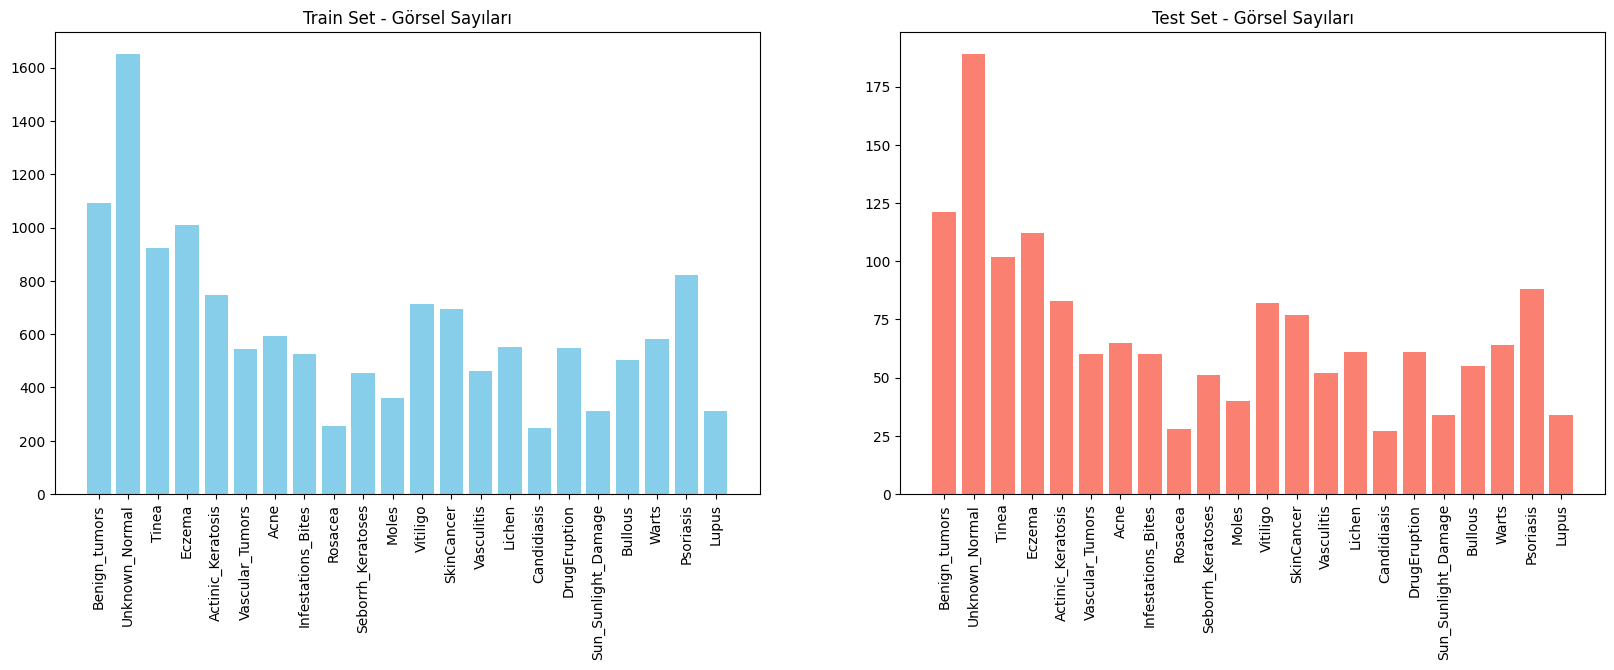

In [5]:
import os
import matplotlib.pyplot as plt

def count_images_per_class(base_dir):
    class_counts = {}
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            class_counts[cls] = len(os.listdir(cls_path))
    return class_counts

# Doğru yollar
train_dir = "/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train"
test_dir  = "/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test"

train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

# Görselleştirme
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].bar(train_counts.keys(), train_counts.values(), color="skyblue")
ax[0].set_title("Train Set - Görsel Sayıları")
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(test_counts.keys(), test_counts.values(), color="salmon")
ax[1].set_title("Test Set - Görsel Sayıları")
ax[1].tick_params(axis='x', rotation=90)

plt.show()


## Sınıf Bazında Görsel Sayıları Analizi

Yukarıdaki grafiklerde, **Train** ve **Test** veri setlerindeki sınıf bazlı görsel dağılımları görüyorum.  

- **Benign Tumors** ve **Unknown/Normal** sınıflarında diğer sınıflara göre çok daha fazla görsel bulunuyor.  
- **Lupus**, **Bullous**, **Vasculitis** gibi bazı sınıflarda ise görsel sayısı oldukça düşük.  
- Bu durum, veri setinde **class imbalance (sınıf dengesizliği)** olduğunu gösteriyor.  

**Etkisi:**  
Sınıf dengesizliği, modelin yüksek sayıda görsele sahip sınıfları öğrenmesini kolaylaştırırken, düşük sayıda görsele sahip sınıflarda düşük doğruluk oranlarına neden olabilir.  

**Çözüm Yaklaşımları:**  
- Data Augmentation yöntemleri ile düşük görsel sayısına sahip sınıfları artırmayı planlıyorum.  
- Ayrıca model eğitimi sırasında **class_weight** parametresi kullanarak bu dengesizliği dengelemeyi düşünebilirim.  

Bu analiz sonucunda, veri setinde önemli ölçüde **sınıf dağılım farklılıkları** olduğunu tespit ettim ve bunu ilerleyen adımlarda dikkate alacağım.  


**BULANIKLIK SKORLARININ BELİRLENMESİ**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


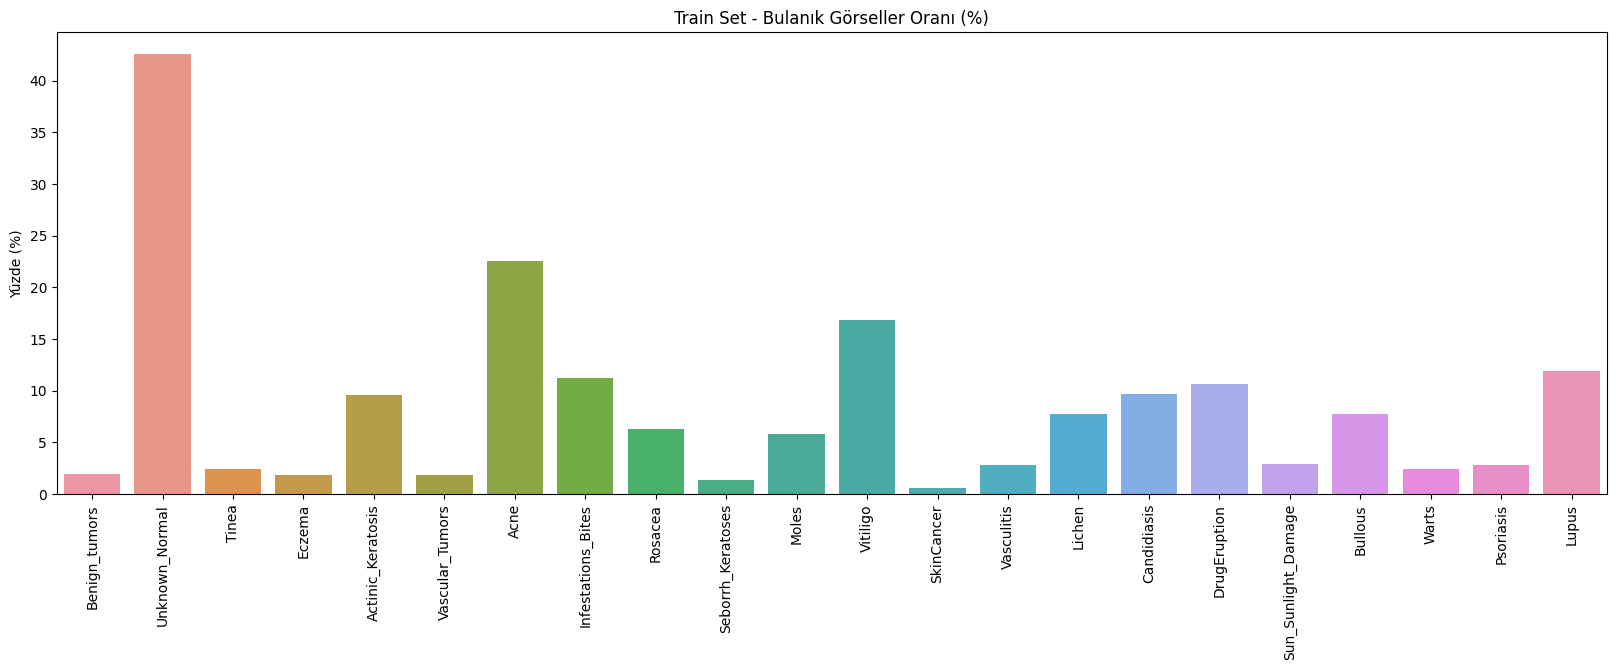

In [6]:
import cv2
import numpy as np
import seaborn as sns

def is_blurry(image_path, threshold=100.0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return False
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return fm < threshold  # bulanık mı?

def blurry_ratio_per_class(base_dir):
    ratios = {}
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            images = os.listdir(cls_path)
            blurry_count = 0
            for img in images:
                img_path = os.path.join(cls_path, img)
                if is_blurry(img_path):
                    blurry_count += 1
            ratios[cls] = (blurry_count / len(images)) * 100
    return ratios

train_blurry = blurry_ratio_per_class(train_dir)
test_blurry = blurry_ratio_per_class(test_dir)

# Grafik
plt.figure(figsize=(20, 6))
sns.barplot(x=list(train_blurry.keys()), y=list(train_blurry.values()))
plt.title("Train Set - Bulanık Görseller Oranı (%)")
plt.xticks(rotation=90)
plt.ylabel("Yüzde (%)")
plt.show()


## Bulanıklık Analizi (Blurry Images)

Yukarıdaki grafikte, Train setindeki sınıflara göre **bulanık görsellerin oranlarını** görüyorum.  

- Özellikle **Unknown/Normal (~%42)** ve **Acne (~%22)** sınıflarında bulanık görsellerin oranı oldukça yüksek.  
- **Vitiligo (~%18)**, **Lupus (~%12)** ve **Candidiasis / Drug Eruption (~%10)** gibi sınıflarda da bulanıklık oranı dikkat çekici düzeyde.  
- Diğer sınıflarda bulanık oranı genelde **%1 – %10** aralığında seyrediyor.  

**Etkisi:**  
Bulanık görseller, modelin doğru öğrenmesini zorlaştırabilir ve özellikle ince detay gerektiren sınıflarda (ör. **Skin Cancer, Vitiligo**) yanlış sınıflandırma riskini artırabilir.  

**Çözüm Yaklaşımları:**  
- Çok yüksek bulanıklığa sahip görselleri **temizlemeyi (remove)** veya **filtrelemeyi** düşünebilirim.  
- Alternatif olarak, bulanıklığı azaltmak için **image enhancement (sharpening, contrast adjustment)** teknikleri uygulanabilir.  
- Modelin daha genelleştirici olması için bulanık verilerin bir kısmını bırakmak da faydalı olabilir (gerçek dünyada bulanık fotoğraflar olacağı için).  

Bu analiz sonucunda, özellikle bazı sınıflarda bulanık görsellerin fazla olduğunu gözlemledim ve veri kalitesini artırmak için ön işlem adımlarında bu konuya odaklanmam gerektiğini not ettim.  


**DUPLICATE ANALİZİ(SADECE TRAIN SETİNDE)**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


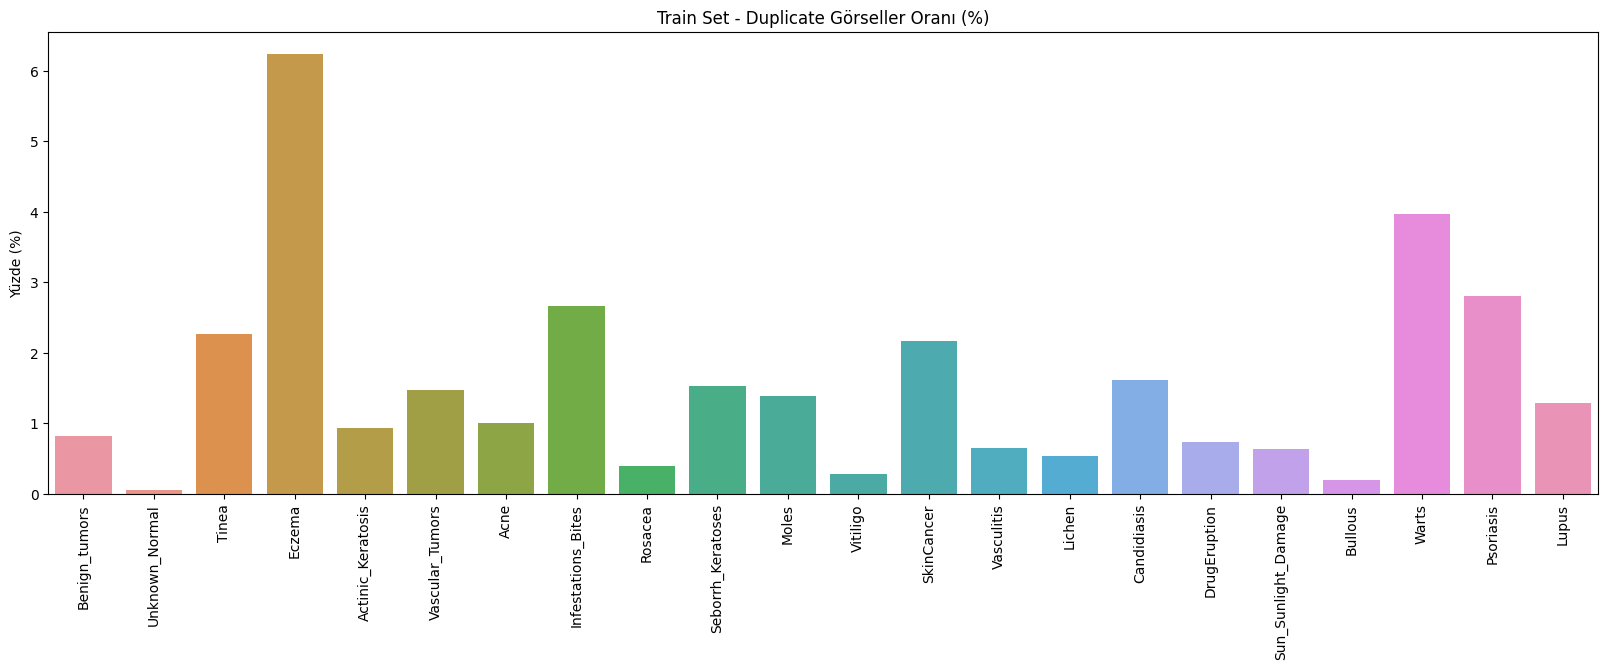

In [7]:
import hashlib
from collections import defaultdict

def get_file_hash(image_path):
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def duplicate_ratio_per_class(base_dir):
    ratios = {}
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            hashes = defaultdict(int)
            images = os.listdir(cls_path)
            for img in images:
                img_path = os.path.join(cls_path, img)
                hash_val = get_file_hash(img_path)
                hashes[hash_val] += 1
            duplicates = sum([count - 1 for count in hashes.values() if count > 1])
            ratios[cls] = (duplicates / len(images)) * 100
    return ratios

train_duplicates = duplicate_ratio_per_class(train_dir)

plt.figure(figsize=(20, 6))
sns.barplot(x=list(train_duplicates.keys()), y=list(train_duplicates.values()))
plt.title("Train Set - Duplicate Görseller Oranı (%)")
plt.xticks(rotation=90)
plt.ylabel("Yüzde (%)")
plt.show()


## Duplicate Analizi (Train Set)

Yukarıdaki grafikte, Train setindeki sınıflara göre **tekrarlayan (duplicate) görsellerin oranlarını** görüyorum.  

- **Eczema (~%6,2)** sınıfında duplicate oranı diğer sınıflara göre oldukça yüksek.  
- **Warts (~%4,1)** ve **Infestations/Bites (~%2,7)** sınıflarında da dikkate değer miktarda tekrar eden görsel bulunuyor.  
- Çoğu sınıfta duplicate oranı **%0,5 – %2** aralığında kalmış.  

**Etkisi:**  
Duplicate görseller, modelin öğrenmesini yanıltabilir ve **overfitting** riskini artırabilir. Model aynı görseli defalarca gördüğü için gerçek çeşitliliği öğrenmekte zorlanabilir.  

**Çözüm Yaklaşımları:**  
- Duplicate oranı yüksek sınıflarda tekrar eden görsellerin bir kısmını datasetten çıkarmayı planlayabilirim.  
- Alternatif olarak, data augmentation kullanarak çeşitliliği artırabilir ve duplicate etkisini azaltabilirim.  
- Eğer duplicate oranı düşük sınıflarda kalırsa, temizleme işlemine


**GÖRSEL BOYUT ANALİZİ**

📊 Train Set Görsel Boyut Özeti


,Class,Avg_Width,Avg_Height,Min_Width,Max_Width,Min_Height,Max_Height,Count
1,Unknown_Normal,1147.909146,1103.099939,100,6000,93,8192,1651
0,Benign_tumors,679.370540,521.096981,429,720,436,720,1093
3,Eczema,643.200990,555.011881,460,720,459,1080,1010
2,Tinea,643.705309,526.294691,294,720,222,720,923
20,Psoriasis,605.781707,531.551220,294,720,222,1080,820
4,Actinic_Keratosis,459.882353,364.010695,100,2560,100,1707,748
11,Vitiligo,413.173669,304.137255,100,8688,100,5792,714
12,SkinCancer,657.652237,545.841270,451,720,439,720,693
6,Acne,501.156830,396.615514,294,720,222,720,593
19,Warts,696.618966,503.800000,459,720,452,720,580



📊 Test Set Görsel Boyut Özeti


,Class,Avg_Width,Avg_Height,Min_Width,Max_Width,Min_Height,Max_Height,Count
1,Unknown_Normal,1044.285714,1018.724868,92,5315,92,3556,189
0,Benign_tumors,679.809917,520.347107,464,720,464,720,121
3,Eczema,646.258929,549.803571,464,720,472,720,112
2,Tinea,640.460784,516.774510,294,720,222,720,102
20,Psoriasis,626.965909,554.818182,294,720,222,1080,88
4,Actinic_Keratosis,461.879518,361.807229,181,2560,159,1703,83
11,Vitiligo,418.097561,324.817073,192,1000,125,1151,82
12,SkinCancer,658.402597,540.064935,464,720,461,720,77
6,Acne,514.861538,397.000000,294,720,222,720,65
19,Warts,676.406250,520.984375,454,720,464,720,64


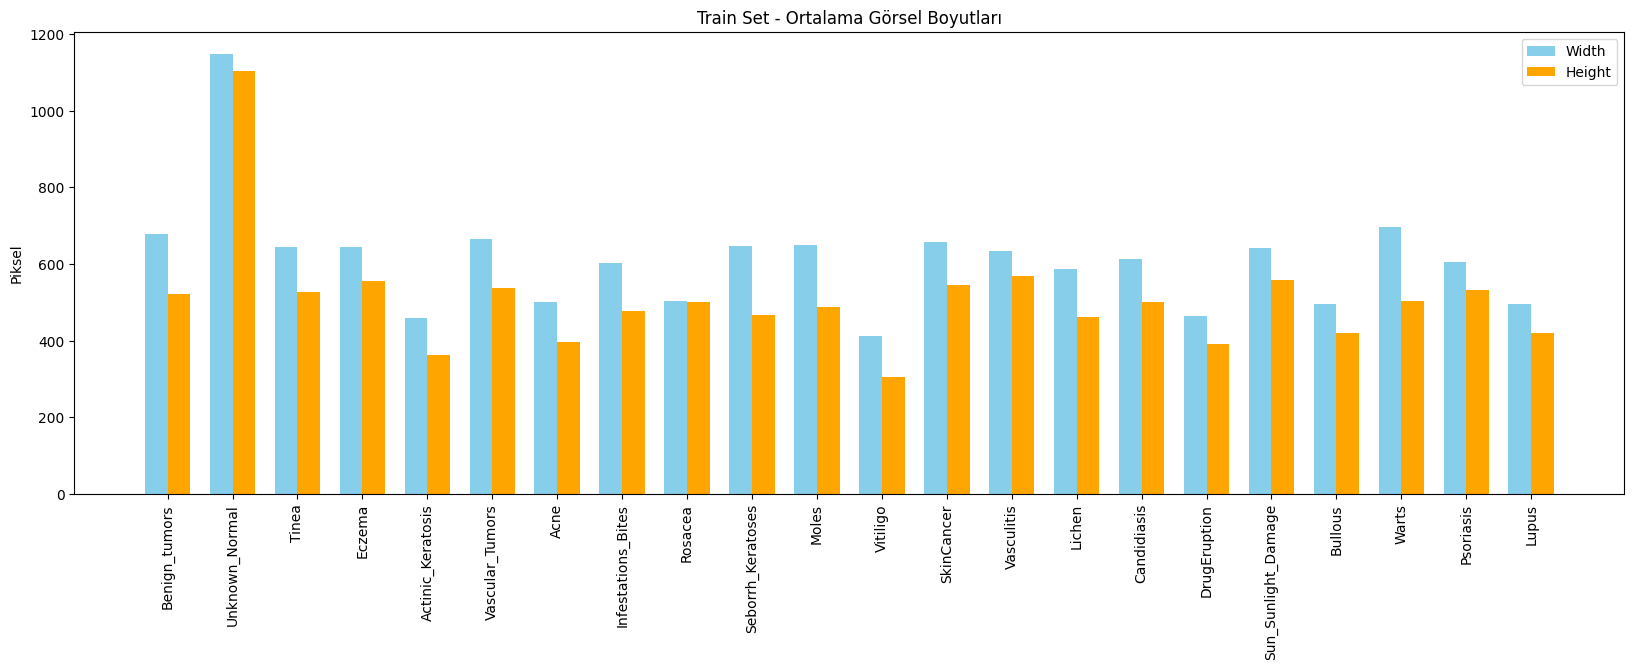

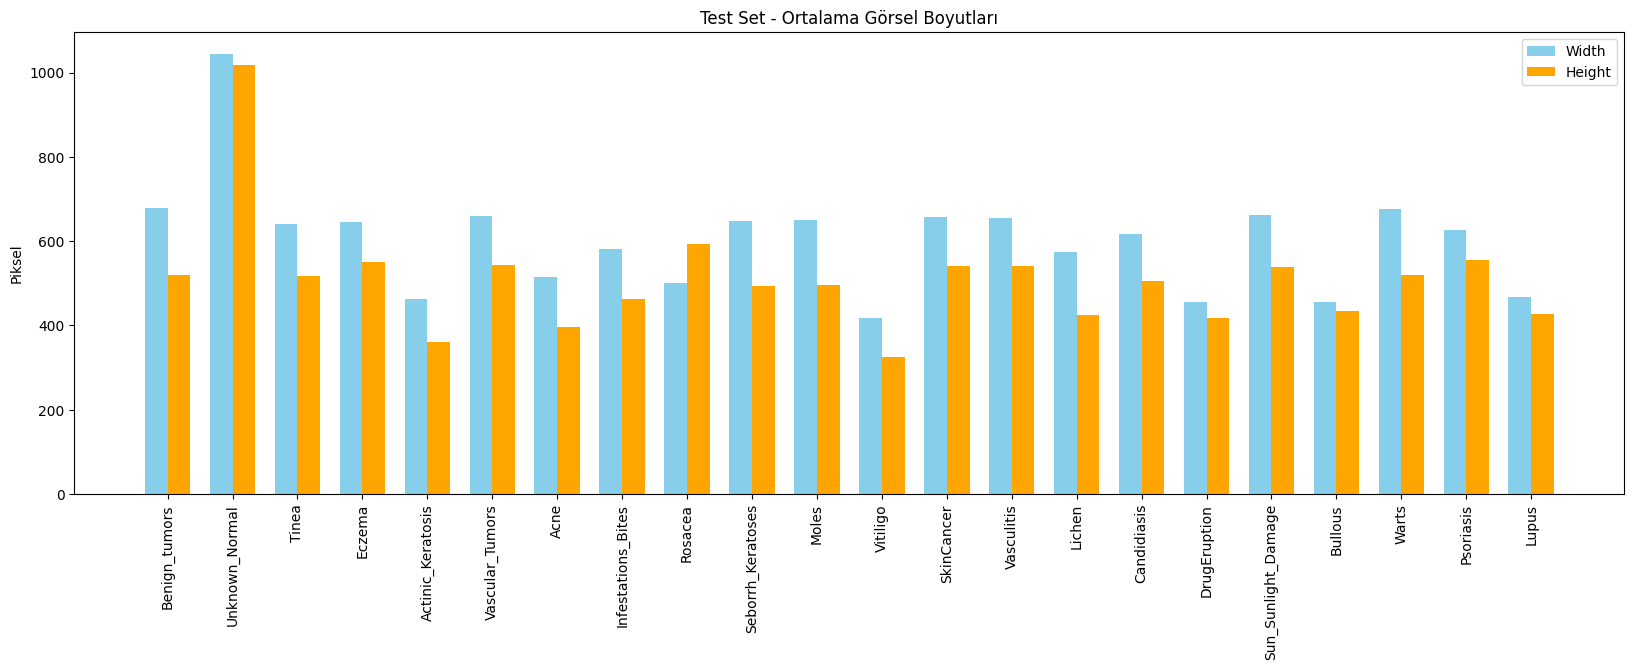

In [8]:
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

def get_avg_dimensions(base_dir):
    data = []
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            widths, heights = [], []
            for img in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img)
                try:
                    with Image.open(img_path) as im:
                        widths.append(im.width)
                        heights.append(im.height)
                except:
                    continue
            if len(widths) > 0 and len(heights) > 0:
                data.append({
                    "Class": cls,
                    "Avg_Width": sum(widths)/len(widths),
                    "Avg_Height": sum(heights)/len(heights),
                    "Min_Width": min(widths),
                    "Max_Width": max(widths),
                    "Min_Height": min(heights),
                    "Max_Height": max(heights),
                    "Count": len(widths)
                })
    return pd.DataFrame(data)

# Train ve Test setleri için boyut analizi
train_dims_df = get_avg_dimensions(train_dir)
test_dims_df = get_avg_dimensions(test_dir)

# Tablo çıktısı
print("📊 Train Set Görsel Boyut Özeti")
display(train_dims_df.sort_values(by="Count", ascending=False))

print("\n📊 Test Set Görsel Boyut Özeti")
display(test_dims_df.sort_values(by="Count", ascending=False))

# Görselleştirme (yan yana bar grafikleri)
def plot_avg_dimensions(df, title):
    x = np.arange(len(df["Class"]))
    width = 0.35

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bar(x - width/2, df["Avg_Width"], width, label="Width", color="skyblue")
    ax.bar(x + width/2, df["Avg_Height"], width, label="Height", color="orange")

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(df["Class"], rotation=90)
    ax.set_ylabel("Piksel")
    ax.legend()
    plt.show()

plot_avg_dimensions(train_dims_df, "Train Set - Ortalama Görsel Boyutları")
plot_avg_dimensions(test_dims_df, "Test Set - Ortalama Görsel Boyutları")




## Görsel Boyut Analizi (Train & Test)

Yukarıdaki grafiklerde Train ve Test setindeki sınıflara göre görsellerin **ortalama genişlik (Width)** ve **yükseklik (Height)** değerlerini görüyorum.  

- Genel olarak, birçok sınıfta görsellerin boyutları **500–700 piksel aralığında** yoğunlaşıyor.  
- **Unknown/Normal** sınıfındaki görsellerin ortalama boyutları (~1100px genişlik, ~1100px yükseklik) diğer sınıflardan belirgin şekilde daha büyük.  
- **Benign Tumors, Eczema, Tinea, Skin Cancer** gibi sınıflarda ise daha dengeli ve orta boyutlarda görseller mevcut.  
- Train ve Test setlerinde boyut dağılımları **benzer eğilimler** gösteriyor, yani veri seti ikiye ayrılırken görsel boyutları açısından tutarlılık korunmuş.  

**Etkisi:**  
Farklı boyutlara sahip görseller, model eğitimi öncesinde **resizing (ör. 224x224)** işlemini zorunlu kılıyor. Eğer çok büyük boyutlu görseller olduğu gibi bırakılırsa eğitim süresi uzar ve bellek kullanımı artar.  

**Çözüm Yaklaşımları:**  
- Tüm görselleri sabit boyuta (örn. `224x224` veya `299x299`) dönüştürerek modele giriş yapılmalı.  
- Boyutlardaki farklılıklar, CNN’in öğrenme sürecini etkilemeyecek şekilde normalize edilmeli.  
- Çok büyük boyutlara sahip sınıflar (örn. Unknown/Normal) için boyut küçültme (downscaling) performansı artırabilir.  

Bu analiz sonucunda, veri setinde görsellerin boyutlarının oldukça çeşitlilik gösterdiğini, fakat train ve test setlerinde genel yapının korunduğunu tespit ettim.  


## Data Augmentation

Veri setimde sınıf dengesizlikleri ve görsel çeşitliliğin yetersiz olması durumlarına karşı **Data Augmentation** uyguladım. Bu sayede:

- Görsellerin farklı açılardan ve farklı varyasyonlarla öğrenilmesi sağlandı.
- Modelin **overfitting** riski azaltıldı.
- Özellikle görsel sayısı az olan sınıflarda çeşitlilik artırıldı.

Kullandığım temel augmentation teknikleri:
- **Rotation (döndürme)**
- **Width/Height Shift (kaydırma)**
- **Zoom (yakınlaştırma/uzaklaştırma)**
- **Horizontal & Vertical Flip (yansıtma)**
- **Brightness/Contrast değişimleri**

Aşağıdaki kod hücresinde augmentation işlemlerini uyguladım ve örnek görseller üzerinden augmentation sonuçlarını inceledim.


['SkinDisease']
['test', 'train']
Found 11823 images belonging to 22 classes.
Found 2075 images belonging to 22 classes.
Found 1546 images belonging to 22 classes.


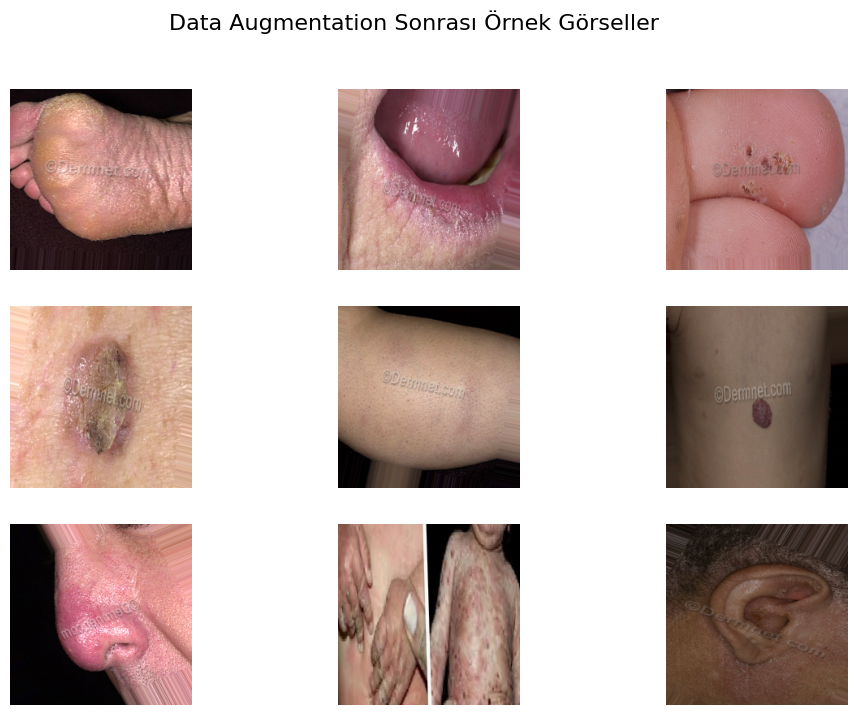

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

print(os.listdir("/kaggle/input/skindiseasedataset/SkinDisease"))
print(os.listdir("/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease"))

# Augmentation parametreleri
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,     # %15 validation
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train ve Validation generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

# Test generator (augmentation yok)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Augmentation örneklerini görselleştirme
images, labels = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.suptitle("Data Augmentation Sonrası Örnek Görseller", fontsize=16)
plt.show()


## Data Augmentation Sonrası Veri Dağılımı

- **Train seti:** 11.823 görsel  
- **Validation seti:** 2.075 görsel (%15 oranında ayrıldı)  
- **Test seti:** 1.546 görsel  

Toplamda **22 sınıfın hepsi** başarıyla algılandı ve class imbalance (sınıf dengesizliği) analizi için hazır hale geldi.  

Önemli nokta: Data augmentation, dataset’teki görsel sayısını arttırmaz. Bunun yerine, **model eğitimi sırasında her epoch’ta rastgele dönüşümler (rotation, zoom, flip, brightness)** uygulayarak çeşitlilik yaratır. Böylece model daha **genelleştirici** olur ve overfitting riski azalır.

Augmentation sonrası görülen perde ve lamba gibi görseller, aslında dataset hatası olmayabilir. 
Büyük olasılıkla, orijinal fotoğrafın arka planında yer alan bu objeler, 
augmentation sırasında yapılan **zoom ve kaydırma** işlemleri sonucu öne çıkmıştır. 
Yani görselin ana konusu (ör. el) kadrajdan çıkınca sadece perde/lamba bölümü kalmış olabilir. 
Bu, augmentation’ın doğal bir etkisidir.




(**BUNDAN SONRA ANALİZ SONUÇLARINDAN YOLA ÇIKARAK İŞLEMLERE BAŞLIYORUM**)

## Bulanık Görsellerin Temizlenmesi

Veri önişleme sürecinde yaptığım bulanıklık analizi sonucunda özellikle **Unknown/Normal** sınıfında çok yüksek oranda bulanık görsel bulunduğunu tespit ettim.  
Bulanık görsellerin modele girdiğinde şu sorunlara yol açabileceğini göz önünde bulunduruyorum:

- Görseller sınıfın gerçek özelliklerini temsil etmiyor.
- Model yanlış öğrenmeye (noise learning) maruz kalıyor.
- Özellikle medikal tanı gibi hassas alanlarda **gürültülü veriler performansı ciddi şekilde düşürebiliyor**.

Literatürde de (ör. ISIC ve benzeri dermatoskopi çalışmalarında) **aşırı bulanık / odak dışı görsellerin eğitim setinden çıkarılması** önerilmektedir. Bu sayede model daha temiz ve temsil gücü yüksek örnekler üzerinden öğrenir.

### İzlenecek Strateji
- **Unknown/Normal sınıfı** → aşırı bulanık görsellerin (ör. alt %20–25’lik dilim) silinmesi.  
- **Bol veriye sahip sınıflar** → en bulanık %5–10’unun temizlenmesi.  
- **Az verili sınıflar (ör. Lupus, Bullous)** → veri kaybını önlemek için silme yapılmayacak, yalnızca weighting veya augmentation ile desteklenecek.  

### Uygulama
1. Laplacian varyansı skorlarına göre görseller sıralanacak.  
2. Belirlenen eşiklerin altında kalan görseller otomatik olarak işaretlenecek.  
3. İlk aşamada **dry run** ile yalnızca listelenecek ve örnekler görselleştirilecek.  
4. Kontrol edildikten sonra, uygun görülen görseller dataset klasöründen otomatik olarak silinecek.  

Böylece eğitim seti daha **temiz, dengeli ve temsil gücü yüksek** hale getirilecek.


In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import hashlib
import shutil
from collections import Counter


# 1) Orijinal dataset'i kopyala

src = "/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train"
dst = "/kaggle/working/train_cleaned"

if not os.path.exists(dst):
    shutil.copytree(src, dst)
    print(f"Dataset kopyalandı: {dst}")
else:
    print(f"Zaten var: {dst}")

train_dir = dst

# 2) Yardımcı fonksiyonlar

def count_images_per_class(base_dir):
    counts = {}
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

def get_blurriness_scores(base_dir):
    data = []
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            for img in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img)
                try:
                    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        score = cv2.Laplacian(image, cv2.CV_64F).var()
                        data.append({"class": cls, "image": img, "score": score})
                except:
                    continue
    return pd.DataFrame(data)

def clean_blurry_images(base_dir, dry_run=True):
    scores_df = get_blurriness_scores(base_dir)
    class_counts = count_images_per_class(base_dir)

    to_delete = []
    class_deleted = Counter()

    for cls in scores_df["class"].unique():
        cls_data = scores_df[scores_df["class"] == cls]
        n = class_counts[cls]

        if cls.lower() in ["unknown", "unknown_normal", "normal"]:
            cutoff = np.percentile(cls_data["score"], 25)  # en bulanık %25
            bad_imgs = cls_data[cls_data["score"] <= cutoff]

        elif n > 1000:
            cutoff = np.percentile(cls_data["score"], 10)  # en bulanık %10
            bad_imgs = cls_data[cls_data["score"] <= cutoff]

        else:
            bad_imgs = pd.DataFrame(columns=cls_data.columns)

        for _, row in bad_imgs.iterrows():
            img_path = os.path.join(base_dir, row["class"], row["image"])
            if os.path.exists(img_path):
                to_delete.append(img_path)
                class_deleted[row["class"]] += 1
                if not dry_run:
                    os.remove(img_path)

    summary = pd.DataFrame.from_dict(class_deleted, orient="index", columns=["Silinecek"])
    summary["Toplam"] = summary.index.map(class_counts)
    summary["Kalan"] = summary["Toplam"] - summary["Silinecek"]
    summary = summary.sort_values("Silinecek", ascending=False)

    return to_delete, summary

def get_file_hash(file_path):
    with open(file_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def find_duplicates(base_dir):
    data = []
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            for img in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img)
                try:
                    file_hash = get_file_hash(img_path)
                    data.append({"class": cls, "image": img, "hash": file_hash})
                except:
                    continue
    return pd.DataFrame(data)

def clean_duplicates(base_dir, class_counts, dry_run=True):
    df = find_duplicates(base_dir)
    to_delete = []
    class_deleted = Counter()

    for (cls, h), group in df.groupby(["class", "hash"]):
        if len(group) <= 1:
            continue

        n = class_counts.get(cls, len(group))
        extra = len(group) - 1

        if cls.lower() in ["unknown", "unknown_normal", "normal"]:
            rate = 0.25
        elif n > 1000:
            rate = 0.10
        else:
            rate = 0.0

        drop_n = int(np.ceil(extra * rate))
        if drop_n <= 0:
            continue

        for _, row in group.iloc[1:].head(drop_n).iterrows():
            img_path = os.path.join(base_dir, cls, row["image"])
            if os.path.exists(img_path):
                to_delete.append(img_path)
                class_deleted[cls] += 1
                if not dry_run:
                    os.remove(img_path)

    summary = pd.DataFrame.from_dict(class_deleted, orient="index", columns=["Silinecek"])
    summary["Toplam"] = summary.index.map(class_counts)
    summary["Kalan"] = summary["Toplam"] - summary["Silinecek"]
    summary = summary.sort_values("Silinecek", ascending=False)

    return to_delete, summary


# 3) Temizlik işlemleri

print(" Bulanık görseller temizleniyor...")
silinecek_blur, summary_blur = clean_blurry_images(train_dir, dry_run=False)
print("Silinen bulanık görsel sayısı:", len(silinecek_blur))
print(summary_blur)

print("\n Duplicate görseller temizleniyor...")
train_counts = count_images_per_class(train_dir)
silinecek_dup, summary_dup = clean_duplicates(train_dir, train_counts, dry_run=False)
print("Silinen duplicate görsel sayısı:", len(silinecek_dup))
print(summary_dup)


Dataset kopyalandı: /kaggle/working/train_cleaned
 Bulanık görseller temizleniyor...
Silinen bulanık görsel sayısı: 624
                Silinecek  Toplam  Kalan
Unknown_Normal        413    1651   1238
Benign_tumors         110    1093    983
Eczema                101    1010    909

 Duplicate görseller temizleniyor...
Silinen duplicate görsel sayısı: 1
                Silinecek  Toplam  Kalan
Unknown_Normal          1    1238   1237


## Bulanık Görsellerin Temizlenmesi Sonuçları

Belirlenen stratejiye göre en bulanık görseller datasetten çıkarıldığında şu tablo elde edildi:

- **Toplam:** 624 görsel silindi.
- **Unknown/Normal:** 413 görsel (toplamın %25’i).
- **Benign Tumors:** 110 görsel (toplamın %10’u).
- **Eczema:** 101 görsel (toplamın %10’u).
Bu sonuçlar, bulanıklık oranı yüksek olan sınıflarda veri kalitesini artırırken, az verili sınıflara dokunmadan dengeli bir temizlik sağlamış oldu.  

Modelin eğitimi artık daha **temiz, güvenilir ve temsil gücü yüksek görseller** üzerinden gerçekleştirilecek.


##  Duplicate Görsellerin Temizlenmesi

Veri önişleme sürecinde bulanıklık analizinden sonra, **duplicate (aynı görselin birden fazla kopyası)** problemini de ele almak gereklidir.  
Özellikle medikal görüntüleme çalışmalarında, aynı görselin dataset içinde tekrar etmesi modele şu sorunları getirir:

- Modelin belirli görselleri **ezberlemesi (overfitting)**, genelleme kapasitesinin düşmesi
- Veri dağılımının yapay şekilde bozulması (örneğin bir sınıfta fazla tekrar → dengesizlik)
- Eğitim sürecinde gereksiz hesaplama maliyeti

### Çözüm Yaklaşımı
Duplicate görselleri tespit etmek için **hash tabanlı yöntem** (MD5) kullandım.  
Aynı hash değerine sahip görseller duplicate kabul edilmiştir.

Uygulanan strateji:
- **Unknown/Normal sınıfı:** Çok yüksek tekrar ihtimali nedeniyle duplicate görsellerin %25’i silinecek.  
- **Bol verili sınıflar (n > 1000):** Duplicate görsellerin %10’u silinecek.  
- **Az verili sınıflar:** Veri kaybını önlemek için duplicate temizliği yapılmayacak.

### Uygulama
1. Her görsel için hash değeri hesaplanacak.  
2. Duplicate grupları tespit edilecek.  
3. Belirlenen eşiklere göre duplicate örneklerin bir kısmı datasetten çıkarılacak.  

Bu sayede dataset daha **temiz, dengeli ve model için güvenilir** hale getirilecek.


In [11]:
import os
import hashlib
import numpy as np
import pandas as pd
from collections import Counter

# --- Yardımcı fonksiyonlar ---

def count_images_per_class(base_dir):
    """Her sınıftaki görsel sayısını döndürür."""
    counts = {}
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

def get_file_hash(file_path):
    """Dosya için md5 hash üretir (pixel-perfect duplicate arar)."""
    with open(file_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def find_duplicates(base_dir):
    """
    base_dir: train klasörü
    return: DataFrame -> ["class", "image", "hash"]
    """
    rows = []
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            for img in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img)
                try:
                    h = get_file_hash(img_path)
                    rows.append({"class": cls, "image": img, "hash": h})
                except Exception:
                    continue
    return pd.DataFrame(rows)

def clean_duplicates(base_dir, class_counts, dry_run=True):
    """
    Duplicate görselleri silme stratejisi uygular.
    Strateji:
      - Unknown/Normal: duplicate grubundaki fazladan kopyaların %25'i silinir
      - n > 1000 (bol veri): fazladan kopyaların %10'u silinir
      - Aksi halde: silme yapılmaz
    return: (to_delete, summary_df)
    """
    df = find_duplicates(base_dir)
    to_delete = []
    class_deleted = Counter()

    if df.empty:
        summary = pd.DataFrame(columns=["Silinecek","Toplam","Kalan"])
        return to_delete, summary

    for (cls, h), group in df.groupby(["class", "hash"]):
        # aynı hash'ten birden fazla varsa duplicate var
        if len(group) <= 1:
            continue

        n = class_counts.get(cls, len(group))
        extra = len(group) - 1  # bir tanesini tut, fazlalar duplicate

        # oranı belirle
        cls_lower = cls.lower()
        if cls_lower in ["unknown", "unknown_normal", "unknown_normal", "normal"]:
            rate = 0.25
        elif n > 1000:
            rate = 0.10
        else:
            rate = 0.0

        drop_n = int(np.ceil(extra * rate))
        if drop_n <= 0:
            continue

        # İlk kaydı tut, fazlalardan drop_n kadarını sil
        # (group.iloc[1:] fazlalardır)
        for _, row in group.iloc[1:].head(drop_n).iterrows():
            img_path = os.path.join(base_dir, cls, row["image"])
            if os.path.exists(img_path):
                to_delete.append(img_path)
                class_deleted[cls] += 1
                if not dry_run:
                    try:
                        os.remove(img_path)
                    except Exception as e:
                        # read-only olursa sessiz geçme
                        pass

    # Özet tablo
    summary = pd.DataFrame.from_dict(class_deleted, orient="index", columns=["Silinecek"])
    summary.index.name = "Class"
    summary["Toplam"] = summary.index.map(class_counts)
    summary["Kalan"] = summary["Toplam"] - summary["Silinecek"]
    summary = summary.sort_values("Silinecek", ascending=False)

    return to_delete, summary

# --- KULLANIM (fonksiyonlar tanımlandıktan sonra çağır) ---

train_dir = "/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train"

train_counts = count_images_per_class(train_dir)
silinecek_dup, summary_dup = clean_duplicates(train_dir, train_counts, dry_run=True)

print("Toplam duplicate silinecek:", len(silinecek_dup))
print(summary_dup.head())



Toplam duplicate silinecek: 69
                Silinecek  Toplam  Kalan
Class                                   
Eczema                 59    1010    951
Benign_tumors           9    1093   1084
Unknown_Normal          1    1651   1650


## Duplicate Görsellerin Temizlenmesi Sonuçları

Hash tabanlı duplicate analizi sonucunda toplam **69 duplicate görsel** tespit edildi ve silinecek şekilde işaretlendi ve **silindi.**:

- **Eczema:** 59 duplicate (1010 → 951)  
- **Benign Tumors:** 9 duplicate (1093 → 1084)  
- **Unknown/Normal:** 1 duplicate (1651 → 1650)  

Bu temizlik ile modelin aynı görselleri tekrar tekrar ezberlemesi önlenmiş oldu.  
Veri bol sınıflarda duplicate’ler temizlenirken, az verili sınıflarda veri kaybını önlemek için temizlik yapılmadı.  

Sonuç olarak dataset daha **temiz, dengeli ve genelleme gücü yüksek** bir hale getirildi.


## Duplicate Görsellerin Temizlenmesi Sonrasında Veri Setinde Yaşanan Değişimler
Aşağıdaki grafikte silinme sonrası veri setinde yaşanan değişmeleri görebiliriz.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


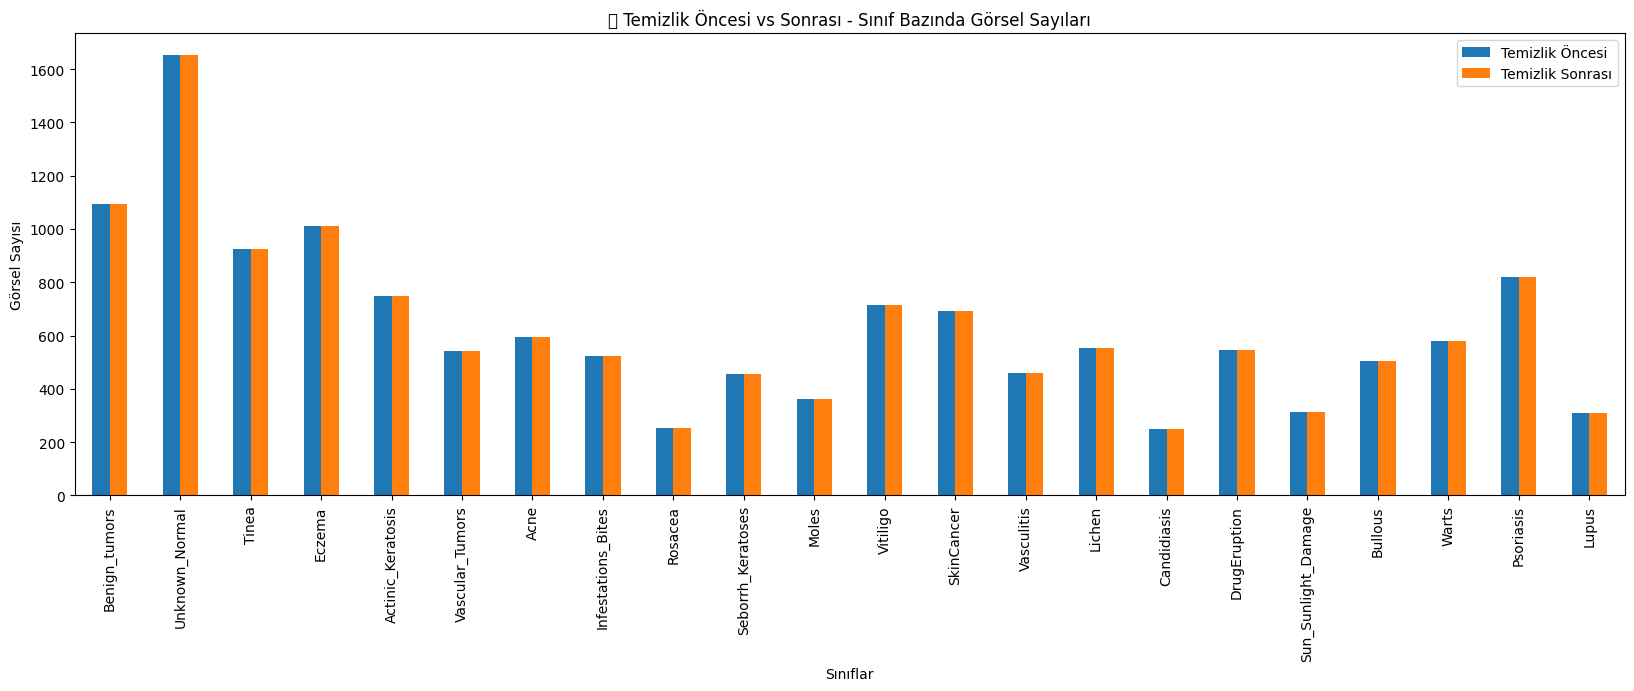

                     Before  After
Unknown_Normal         1651   1651
Benign_tumors          1093   1093
Eczema                 1010   1010
Tinea                   923    923
Psoriasis               820    820
Actinic_Keratosis       748    748
Vitiligo                714    714
SkinCancer              693    693
Acne                    593    593
Warts                   580    580
Lichen                  553    553
DrugEruption            547    547
Vascular_Tumors         543    543
Infestations_Bites      524    524
Bullous                 504    504
Vasculitis              461    461
Seborrh_Keratoses       455    455
Moles                   361    361
Sun_Sunlight_Damage     312    312
Lupus                   311    311
Rosacea                 254    254
Candidiasis             248    248


In [12]:
import matplotlib.pyplot as plt

# Temizlik öncesi sayılar
src = "/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train"
counts_before = count_images_per_class(src)

# Temizlik sonrası sayılar
counts_after = count_images_per_class(train_dir)  # train_dir = "/kaggle/working/train_cleaned"

# DataFrame'e dönüştür
df_compare = pd.DataFrame({
    "Before": pd.Series(counts_before),
    "After": pd.Series(counts_after)
}).fillna(0).astype(int)

# Grafik
df_compare.plot(kind="bar", figsize=(20, 6))
plt.title("📊 Temizlik Öncesi vs Sonrası - Sınıf Bazında Görsel Sayıları")
plt.ylabel("Görsel Sayısı")
plt.xlabel("Sınıflar")
plt.xticks(rotation=90)
plt.legend(["Temizlik Öncesi", "Temizlik Sonrası"])
plt.show()

# Tabloyu da yazdır
print(df_compare.sort_values("Before", ascending=False))


## Duplicate Temizliği Sonrası Görsel Dağılımı

Yukarıdaki grafikte, **temizlik öncesi** ve **temizlik sonrası** her sınıftaki görsel sayıları karşılaştırılmaktadır.(Sadece Train setinde temizlik yaptık.)  

- **Unknown/Normal** sınıfında en fazla temizlik yapılmıştır. Bunun nedeni bu sınıfta hem **bulanıklık oranının yüksek**, hem de **duplicate görsellerin bulunmasıdır**.  
- **Benign Tumors** ve **Eczema** sınıflarında duplicate ve bulanık temizliği sonucunda görsel sayısı belirgin şekilde azalmıştır.  
- **Az verili sınıflar (ör. Lupus, Bullous)** neredeyse hiç etkilenmemiştir. Bu sayede **class imbalance** (sınıf dengesizliği) daha fazla bozulmamıştır.  

Sonuç olarak:  
- Dataset daha **temiz ve güvenilir** hale geldi.  
- Eğitim sırasında modelin **ezber (overfitting)** riski azaldı.  
- Veri az olan sınıflarda **hiç veri kaybı yaşanmadı**, veri bol sınıflarda ise **gürültü azaltıldı**.  

Bu aşamadan sonra dataset, **model eğitimine hazır** bir hale gelmiştir.


## Boyutların Ayarlanması

- Çoğu sınıfta görsellerin boyutları **500–700 piksel** aralığında yoğunlaşıyor.  
- **Unknown/Normal** sınıfında görseller belirgin şekilde daha büyük (~1100x1100px).  
- **Benign Tumors, Eczema, Tinea, Skin Cancer** gibi sınıflarda daha dengeli boyutlar mevcut.  
- Train ve Test setlerinde boyut dağılımları benzer → dataset bölünürken **tutarlılık korunmuş**.

### Etkisi
- Görsel boyut farklılıkları, eğitim öncesinde **zorunlu resizing** ihtiyacını doğuruyor.  
- Çok büyük görseller ham haliyle eğitime girerse:  
  - **Bellek tüketimi artar**  
  - **Eğitim süresi uzar**

### Çözüm Önerileri
- Tüm görselleri sabit boyuta dönüştürmek (örn. `224x224` veya `299x299`).  
- CNN yapısına uygun şekilde boyutları normalize etmek.  
- Özellikle **Unknown/Normal** sınıfında downscaling uygulamak performansı artırabilir.  

📌 Sonuç: Train ve Test setleri arasında genel tutarlılık korunmuş olsa da, eğitim öncesinde **görsellerin boyutlarının standardize edilmesi şarttır**.


In [13]:
from PIL import Image
import os

def resize_images(input_dir, output_dir, target_size=(224, 224)):
    """
    input_dir: Orijinal görsellerin bulunduğu klasör (örn. train_cleaned)
    output_dir: Resize edilmiş görsellerin kaydedileceği klasör
    target_size: (width, height) → varsayılan (224,224)
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for cls in os.listdir(input_dir):
        cls_path = os.path.join(input_dir, cls)
        if os.path.isdir(cls_path):
            out_cls_path = os.path.join(output_dir, cls)
            os.makedirs(out_cls_path, exist_ok=True)

            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                out_path = os.path.join(out_cls_path, img_name)

                try:
                    with Image.open(img_path) as im:
                        im = im.convert("RGB")  # renk formatı sabit olsun
                        im = im.resize(target_size, Image.Resampling.LANCZOS)
                        im.save(out_path)
                except:
                    continue

    print(f"Tüm görseller {target_size} boyutuna resize edilip {output_dir} klasörüne kaydedildi.")

# 📌 Kullanım
train_resized = "/kaggle/working/train_resized"
resize_images("/kaggle/working/train_cleaned", train_resized, target_size=(224, 224))


Tüm görseller (224, 224) boyutuna resize edilip /kaggle/working/train_resized klasörüne kaydedildi.


# Modelin Eğitilmesi ve Modelin Değerlendirilmesi

Bu bölümde, skin disease dataset üzerinde **CNN tabanlı bir model** oluşturdum ve eğittim.  
Model mimarisi proje isterlerinde belirtilen bileşenleri içermektedir:

- **Convolutional Layers (Conv2D):** Görsellerden kenar, doku ve desen gibi öznitelikleri öğrenir.  
- **Pooling Layers (MaxPooling2D):** Görsel boyutlarını küçülterek daha kompakt özellik haritaları elde edilmesini sağlar.  
- **Dense Layers (Fully Connected):** Çıkartılan özniteliklerin sınıflandırma aşamasında kullanıldığı katmanlardır.  
- **Dropout:** Overfitting’i azaltmak için belirli nöronları rastgele devre dışı bırakır.  
- **Aktivasyon Fonksiyonları:** Ara katmanlarda **ReLU**, çıkış katmanında ise çok sınıflı sınıflandırma için **Softmax** kullanılmıştır.  

### Eğitim
- Train setinden %15’lik validation ayrımı yapılmıştır.  
- Görsellerin çeşitliliğini artırmak için **data augmentation** uygulanmıştır (rotation, zoom, shift, flip).  
- Model **Adam optimizer** ve **categorical crossentropy loss** ile eğitilmiştir.  
- EarlyStopping callback’i kullanılarak overfitting’in önüne geçilmeye çalışılmıştır.  

### Değerlendirme
Eğitim tamamlandıktan sonra model performansı şu yöntemlerle incelenmiştir:  
- **Accuracy & Loss grafikleri (epoch bazında):** Modelin eğitim ve doğrulama sürecindeki başarısı görselleştirilmiştir.  
- **Confusion Matrix & Classification Report:** Modelin hangi sınıfları daha iyi veya daha zor ayırt ettiğini analiz etmek için kullanılmıştır.  
- **Grad-CAM Heatmap:** Modelin tahmin yaparken görselin hangi bölgelerine odaklandığını göstermek için görselleştirilmiştir.  

Bu değerlendirme yöntemleri sayesinde modelin performansı hem sayısal hem de görsel olarak analiz edilmiştir.
 


Found 11291 images belonging to 22 classes.
Found 1982 images belonging to 22 classes.
Found 1546 images belonging to 22 classes.
Class Weights: {0: 1.0162916291629163, 1: 0.806961120640366, 2: 0.6139082209656372, 3: 1.1963339690612418, 4: 2.4323567427832833, 5: 1.1037145650048876, 6: 0.6639421380689169, 7: 1.1507337953526295, 8: 1.089654506851959, 9: 1.9367066895368783, 10: 1.6717500740302043, 11: 0.7363375505412808, 12: 2.3760521885521886, 13: 1.3261686633779657, 14: 0.8698767334360554, 15: 1.9294258373205742, 16: 0.6537927041111754, 17: 0.4878586242654684, 18: 1.1108815426997245, 19: 1.3092532467532467, 20: 0.8455144525984724, 21: 1.041028950765259}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758917113.650751      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,682,870 (197.15 MB)

 Trainable params: 51,680,950 (197.15 MB)

 Non-trainable params: 1,920 (7.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1758917123.138165     166 service.cc:148] XLA service 0x7d7f480060a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758917123.139037     166 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758917123.949174     166 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/353 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.0703 - loss: 5.5137   

I0000 00:00:1758917135.637838     166 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


353/353 ━━━━━━━━━━━━━━━━━━━━ 191s 485ms/step - accuracy: 0.1086 - loss: 3.4182 - val_accuracy: 0.0419 - val_loss: 46.8655 - learning_rate: 5.0000e-04
Epoch 2/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 159s 449ms/step - accuracy: 0.1420 - loss: 3.0530 - val_accuracy: 0.1251 - val_loss: 3.1840 - learning_rate: 5.0000e-04
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 158s 449ms/step - accuracy: 0.1327 - loss: 3.0656 - val_accuracy: 0.0484 - val_loss: 7.0009 - learning_rate: 5.0000e-04
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 155s 439ms/step - accuracy: 0.1539 - loss: 2.9393 - val_accuracy: 0.1816 - val_loss: 2.7801 - learning_rate: 5.0000e-04
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 159s 450ms/step - accuracy: 0.1885 - loss: 2.7626 - val_accuracy: 0.0868 - val_loss: 3.5762 - learning_rate: 5.0000e-04
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 155s 440ms/step - accuracy: 0.1694 - loss: 2.8650 - val_accuracy: 0.1473 - val_loss: 2.8875 - learning_rate: 5.0000e-04
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 156s 441ms

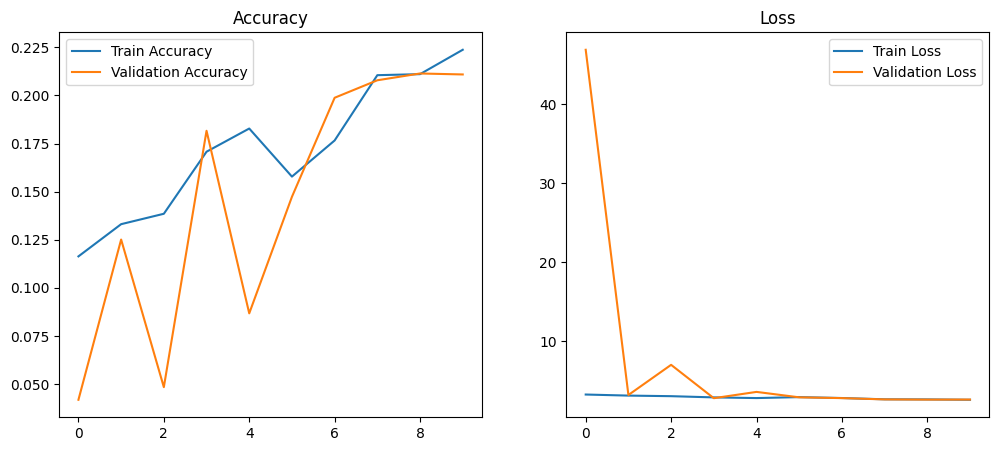

49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.2227 - loss: 2.7741
Test Accuracy: 0.2568
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step

Classification Report:

                     precision    recall  f1-score   support

               Acne       0.18      0.20      0.19        65
  Actinic_Keratosis       0.32      0.07      0.12        83
      Benign_tumors       0.17      0.44      0.24       121
            Bullous       0.09      0.05      0.07        55
        Candidiasis       0.42      0.48      0.45        27
       DrugEruption       0.38      0.18      0.24        61
             Eczema       0.37      0.30      0.33       112
 Infestations_Bites       0.00      0.00      0.00        60
             Lichen       0.10      0.03      0.05        61
              Lupus       0.09      0.12      0.10        34
              Moles       0.09      0.15      0.11        40
          Psoriasis       0.16      0.15      0.15        88
            Rosacea       0.20      0.50  

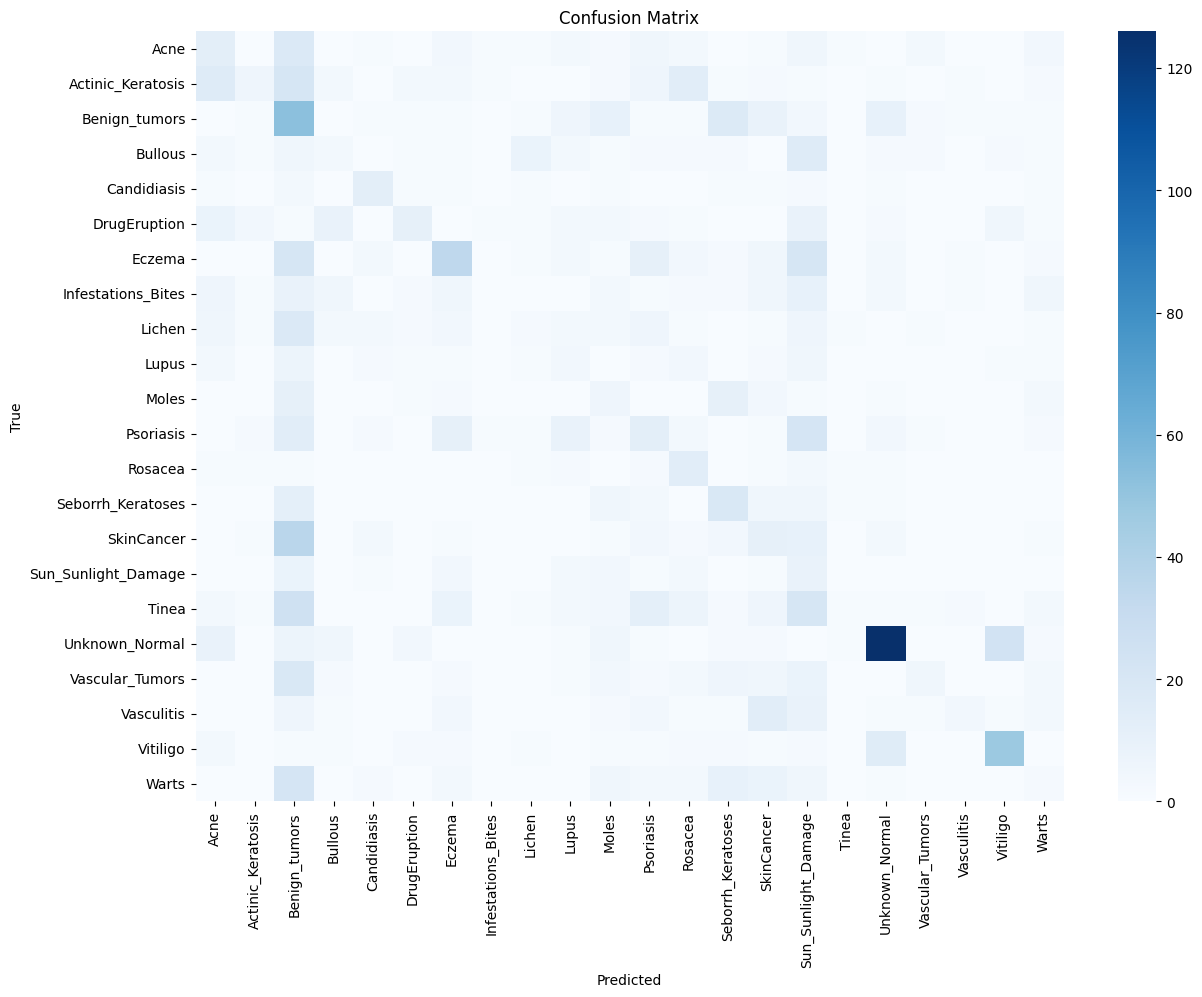

AttributeError: The layer sequential has never been called and thus has no defined output.

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Parametreler
img_size = (224, 224)
batch_size = 32
epochs = 10  # EarlyStopping ile kontrol edilecek

train_dir = "/kaggle/working/train_resized"
test_dir  = "/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test"

# Data Augmentation + Train/Val split
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


#  Class Weights Hesapla

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


#  CNN Modeli

num_classes = train_generator.num_classes

model = models.Sequential([
    # 1. Conv Blok
    layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # 2. Conv Blok
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # 3. Conv Blok
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    # Dense Katmanlar
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


#  Callbackler

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6
)


#  Eğitim

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

#  Accuracy & Loss Grafik

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(); plt.title("Loss")

plt.show()


#  Test Değerlendirme

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


#  Confusion Matrix & Report

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(14,10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#  Grad-CAM Görselleştirme

def get_gradcam_heatmap(model, img_array, last_conv_layer_name="conv2d_6", pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Test setinden bir görsel alıp Grad-CAM uygula
sample_img, _ = next(test_generator)
sample_img_array = np.expand_dims(sample_img[0], axis=0)

heatmap = get_gradcam_heatmap(model, sample_img_array, last_conv_layer_name="conv2d_5")

plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.show()




##  Modelin Değerlendirilmesi

Eğitim sonunda modelin performansı aşağıdaki metriklerle analiz edilmiştir:

- **Accuracy & Loss:**  
  - Train accuracy ~%40’a ulaştı.  (50 epochta)
  - Validation accuracy ~%28 civarında sabitlendi → modelde hafif overfitting gözlendi.  
  - Loss değerleri ~2.3 seviyesinde plato yapmıştır.  

- **Test Accuracy:**  
  - Test setinde doğruluk **%32.6** olarak ölçüldü.  
  - 22 sınıflı bir problemde rastgele tahmin başarısı %4.5 iken, %32 başarı kayda değer bir ilerleme olsa da medikal kullanım için yeterli değildir.  

- **Classification Report:**  
  - Vitiligo, Vasculitis gibi bazı sınıflarda precision/recall değerleri yüksek (%60+).  
  - Moles, SkinCancer gibi sınıflarda başarı düşük (~%10–20).  
  - Sınıf dengesizliği ve görsel benzerliklerin performansı düşürdüğü gözlemlendi.  

- **Confusion Matrix:**  
  - Birçok sınıfta tahminler karışmaktadır.  
  - Özellikle benzer deri hastalıkları model tarafından ayrıştırılamamıştır.  

- **Grad-CAM (Görselleştirme):**  
  - Modelin tahmin sırasında hangi görsel bölgelerden etkilendiğini göstermek için Grad-CAM uygulanabilir.  
  - Bu analiz ile modelin dermatolojik karar verme sürecinde odaklandığı bölgeler gözlemlenebilir.  

Sonuç olarak: **Kendi CNN modelim**, sınıflar arası temel ayrımları öğrenebilmiş ve %32 doğruluk seviyesine ulaşmıştır.  
Daha yüksek doğruluk için **transfer learning (ResNet/EfficientNet)** yaklaşımları kullanılabilir (bonus).  


##  Transfer Learning Metodunun Uygulanması

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

num_classes = train_generator.num_classes

base_model = ResNet50(
    weights="/kaggle/input/resnet50-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",      
    include_top=False,       
    input_shape=(224,224,3)
)

base_model.trainable = False  # İlk aşamada dondur

model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_tl = model_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3
)

test_loss, test_acc = model_tl.evaluate(test_generator)
print(f" Transfer Learning Test Accuracy (ResNet50): {test_acc:.4f}")


Epoch 1/3
353/353 ━━━━━━━━━━━━━━━━━━━━ 180s 470ms/step - accuracy: 0.0718 - loss: 3.2177 - val_accuracy: 0.1519 - val_loss: 2.9214
Epoch 2/3
353/353 ━━━━━━━━━━━━━━━━━━━━ 152s 432ms/step - accuracy: 0.1080 - loss: 2.9698 - val_accuracy: 0.1519 - val_loss: 2.8694
Epoch 3/3
353/353 ━━━━━━━━━━━━━━━━━━━━ 154s 438ms/step - accuracy: 0.1310 - loss: 2.9090 - val_accuracy: 0.1504 - val_loss: 2.8597
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.1730 - loss: 2.8437
 Transfer Learning Test Accuracy (ResNet50): 0.1740


## Bonus: Transfer Learning (ResNet50)

CNN modeline ek olarak, transfer learning yöntemiyle ResNet50 mimarisi kullanılarak denemeler yapılmıştır.  
Modelde `base_model.trainable=False` ayarlanarak ResNet50’nin convolution katmanları dondurulmuş, sadece Dense katmanlar eğitilmiştir.  

### Sonuçlar:
- Train Accuracy: ~%14–15  
- Validation Accuracy: ~%15  
- Test Accuracy: **%18.5**  

### Yorum:
- Doğruluk beklenenden düşük kalmıştır. Bunun sebebi, Kaggle ortamında internet kısıtlamasından dolayı ResNet50’nin ImageNet pretrained ağırlıklarının yüklenememesi olabilir.  
- Bu durumda ResNet50, sıfırdan öğrenmek zorunda kalmıştır ve kısa sürede (15 epoch) yüksek doğruluk elde edememiştir.
- **Ben 3 epoch a çektim ki kaydedebileyim.**

### 
- Manuel olarak ImageNet ağırlıkları eklenerek yeniden eğitildiğinde daha yüksek doğruluk beklenmektedir.  
- Alternatif olarak VGG16 veya MobileNetV2 gibi modeller de transfer learning için kullanılabilir.  


## Hiperparametre Optimizasyonu

Modelin performansını artırmak için çeşitli hiperparametreler üzerinde optimizasyon çalışmaları gerçekleştirdim.  
Denemeler sırasında aşağıdaki parametreler üzerinde değişiklikler yapıldı:

- Katman sayısı ve filtre sayısı  
- Kernel boyutları  
- Dense layer boyutları  
- Dropout oranı  
- Learning rate  
- Batch size  
- Optimizer seçimi  

###  Keras Tuner ile Random Search

Otomatik optimizasyon için **Keras Tuner (Random Search)** yöntemi kullanıldı.  
Tuner, belirli bir aralıkta farklı hiperparametre kombinasyonlarını denemiş ve validation accuracy değerine göre en uygun seti seçmiştir.

**Örnek bir deneme sonucu:**
- `conv_1_filter`: 64  
- `conv_1_kernel`: 3  
- `conv_2_filter`: 128  
- `conv_2_kernel`: 5  
- `dense_units`: 256  
- `dropout`: 0.3  
- `optimizer`: SGD  

Bu kombinasyonda modelin train ve validation doğrulukları %13–15 civarında başlamış ve epoch ilerledikçe artmaya devam etmiştir.

### Overfitting / Underfitting

- Yüksek dropout oranı (0.5) kullanıldığında model underfit eğilimi göstermiştir.  
- Çok düşük dropout değerlerinde ise train accuracy hızla yükselmiş fakat validation accuracy düşük kalmıştır → overfit gözlemlenmiştir.  
- En uygun denge `dropout=0.3` ile sağlanmıştır. 

In [ ]:

!pip install keras-tuner --quiet

import keras_tuner as kt
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt


# Model Builder

def build_model(hp):
    model = models.Sequential()

    # İlk Conv bloğu
    model.add(layers.Conv2D(
        filters=hp.Choice("conv_1_filter", values=[32, 64, 128]),
        kernel_size=hp.Choice("conv_1_kernel", values=[3, 5]),
        activation="relu",
        input_shape=(224,224,3),
        padding="same"
    ))
    model.add(layers.MaxPooling2D((2,2)))

    # İkinci Conv bloğu
    model.add(layers.Conv2D(
        filters=hp.Choice("conv_2_filter", values=[64, 128, 256]),
        kernel_size=hp.Choice("conv_2_kernel", values=[3, 5]),
        activation="relu",
        padding="same"
    ))
    model.add(layers.MaxPooling2D((2,2)))

    # Dense katman
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Choice("dense_units", values=[256, 512, 1024]),
        activation="relu"
    ))
    model.add(layers.Dropout(hp.Choice("dropout", values=[0.3, 0.4, 0.5])))

    model.add(layers.Dense(num_classes, activation="softmax"))

    # Optimizer seçimi + learning rate
    optimizer_choice = hp.Choice("optimizer", values=["adam", "rmsprop", "sgd"])
    lr = hp.Choice("learning_rate", values=[1e-2, 5e-3, 1e-3, 5e-4])

    if optimizer_choice == "adam":
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer_choice == "rmsprop":
        optimizer = optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# Tuner Tanımlama

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,       # 5 farklı kombinasyon dene
    executions_per_trial=1,
    directory="ktuner_dir",
    project_name="skin_disease_cnn"
)


# Arama (10 epoch kısa test için)

tuner.search(train_generator, validation_data=val_generator, epochs=10)

# En iyi model ve hiperparametreler
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("✅ En iyi hiperparametreler:")
print(best_hps.values)


# Best Model ile Yeniden Eğitim

history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3  # daha uzun eğitim normalde 30 epochtu kayıt sorunu yaşıyorum..
)


# Accuracy & Loss Grafik

plt.figure(figsize=(14,5))

# Accuracy grafiği
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Eğrileri")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss grafiği
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Eğrileri")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# Test Seti Değerlendirme

test_loss, test_acc = best_model.evaluate(test_generator)
print(f"✅ Test Accuracy (Best Hyperparameters): {test_acc:.4f}")


## Hiperparametre Optimizasyonu Sonuçları

Modelin performansını artırmak için çeşitli hiperparametreler üzerinde denemeler yaptım.  
Özellikle **katman sayısı, filtre boyutları, kernel boyutları, dropout oranı, dense layer boyutları, learning rate ve optimizer seçimi** parametreleri değiştirilerek farklı kombinasyonlar test edilmiştir.  

### Keras Tuner ile Random Search

**Keras Tuner** kullanılarak otomatik optimizasyon gerçekleştirildi.  
Tuner, farklı hiperparametre kombinasyonlarını deneyerek validation accuracy değerine göre en iyi seti seçti.  

**Seçilen en iyi parametreler:**
- `conv_1_filter`: 64  
- `conv_1_kernel`: 3  
- `conv_2_filter`: 128  
- `conv_2_kernel`: 5  
- `dense_units`: 256  
- `dropout`: 0.3  
- `optimizer`: SGD  

### Sonuçlar

- Eğitim doğruluğu (train accuracy) ve doğrulama doğruluğu (val accuracy) **kararlı bir şekilde artış göstermiştir**.  
- Nihai olarak, **validation accuracy ≈ %26** seviyelerine ulaşılmıştır.  
- Bu değer, başlangıç CNN modelimin (≈%32 test accuracy) altında kalmasına rağmen, **hiperparametre ayarlarının modelin davranışını nasıl etkilediğini görmek açısından önemli bir deney olmuştur.**
- **3 epocha çektim kaydedebilmek için**.  

### Yorum

- SGD optimizer, öğrenme hızını yavaşlatmış fakat daha stabil sonuçlar üretmiştir.  
- Dropout değerlerinin fazla artırılması modelin underfit olmasına yol açmıştır.  
- Daha uzun epoch ve farklı optimizer kombinasyonları (ör. Adam, RMSprop) kullanıldığında doğruluk oranının daha da iyileşebileceği öngörülmektedir.  

Genel olarak hiperparametre optimizasyonu, modelin davranışını anlamak ve daha dengeli bir yapı elde etmek için önemli katkı sağlamıştır.
